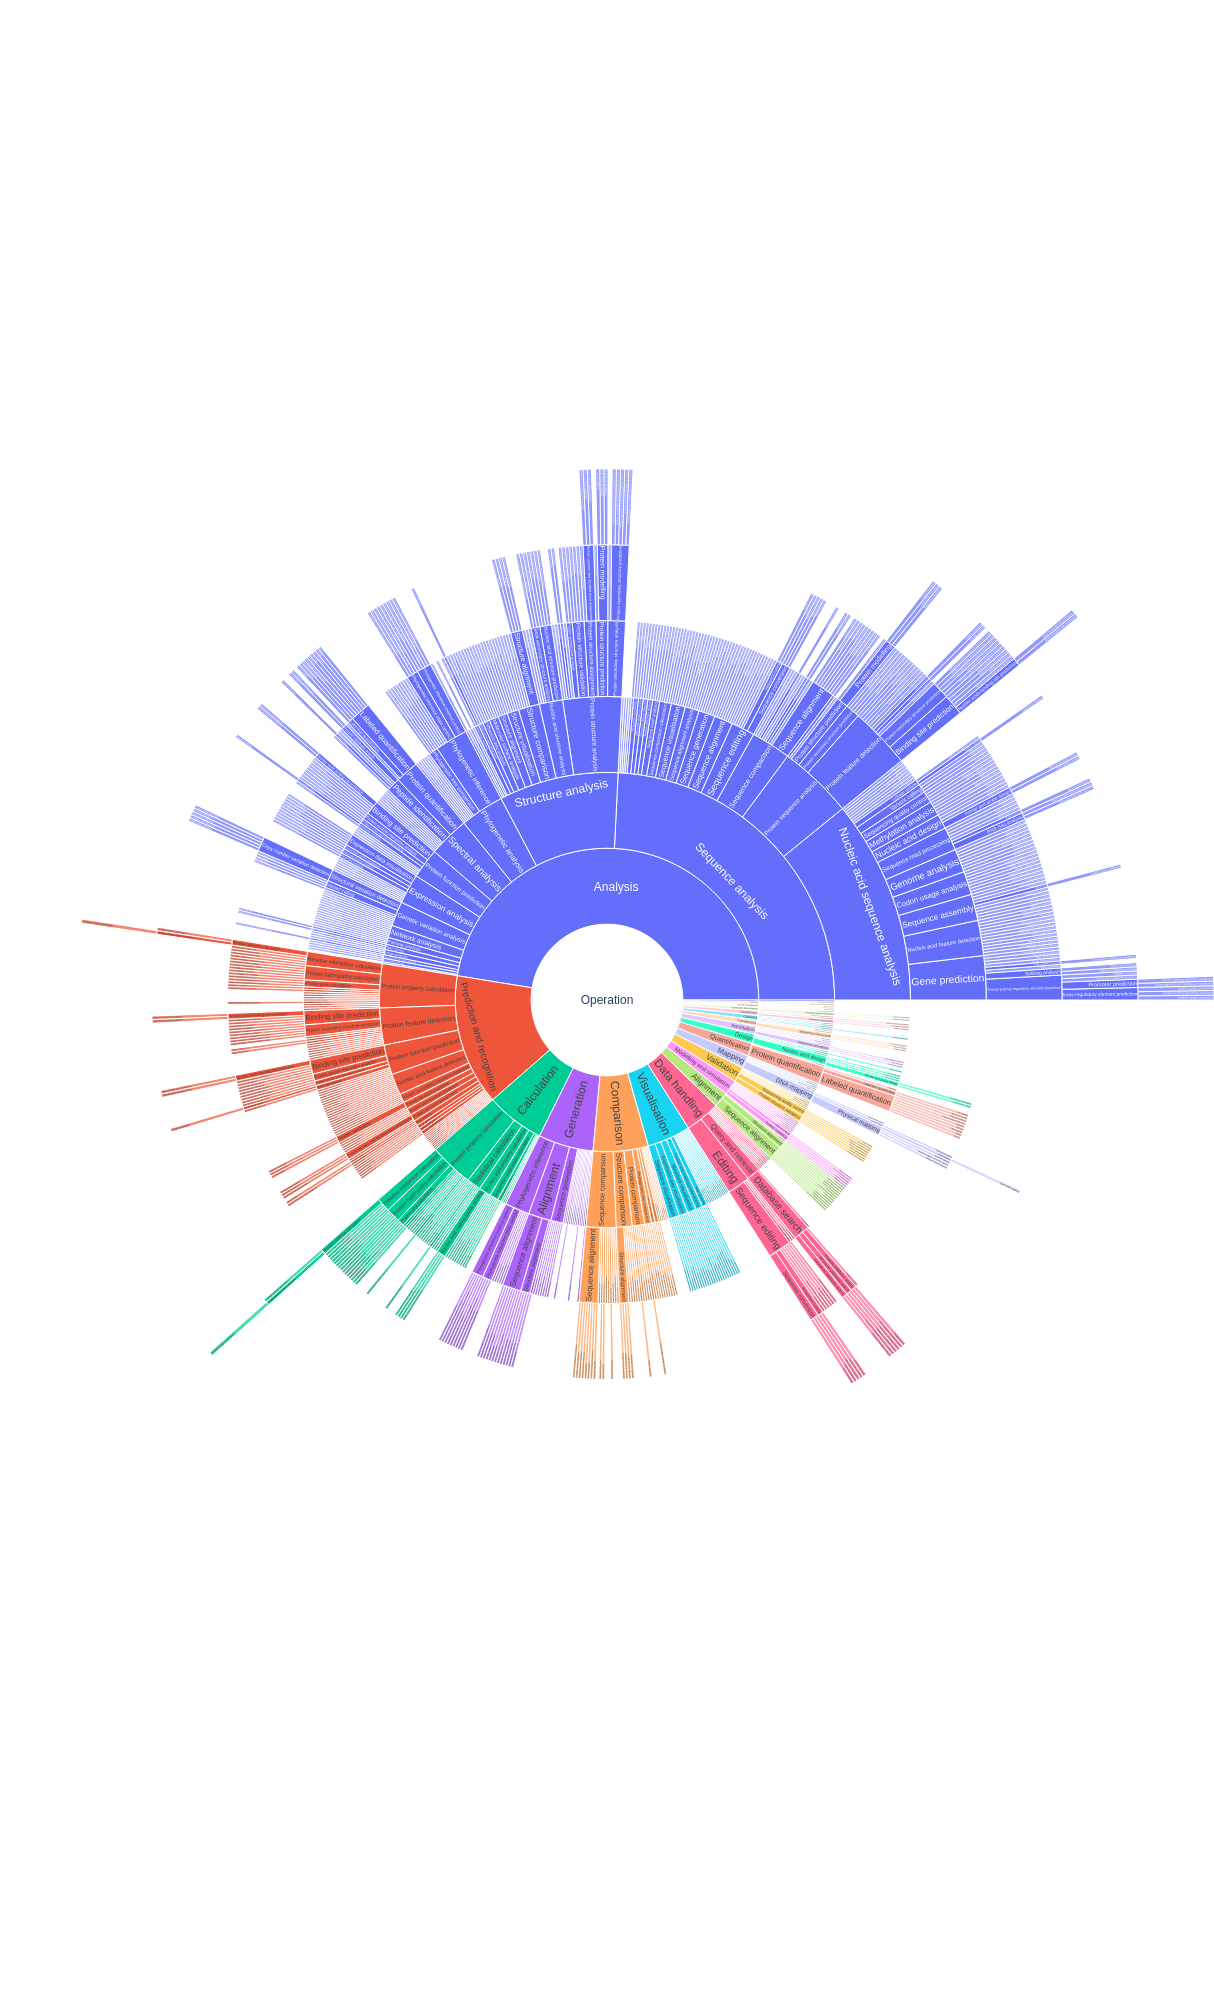

In [1]:
from owlready2 import get_ontology, destroy_entity
import plotly.graph_objects as go

EDAM_FILE_PATH = "data/EDAM_dev.owl"
EDAM = get_ontology(EDAM_FILE_PATH)
EDAM.load(reload=True)
destroy_entity(EDAM["format_2350"])

def class_label(class_node):
    try:
        return class_node.label.first()
    except:
        return class_node.iri


def get_sunburst_data(node, sunburst_data=None, path="", value_fn=lambda x:1):
    if sunburst_data==None:
        sunburst_data = {
                 "ids":[],
                 "labels":[],
                 "parents":[],
                 "values":[]}
    value = value_fn(node)
    id = f"{path}>{node.name}"
    sunburst_data["ids"].append(id)
    sunburst_data["labels"].append(class_label(node))
    sunburst_data["parents"].append(path)
    sunburst_data["values"].append(value)
    for child in node.subclasses():
        sunburst_data, child_value = get_sunburst_data(child, sunburst_data, id, value_fn)
    return sunburst_data, value

def display_sunburst(sunburst_data):
    fig =go.Figure(go.Sunburst(
        ids = sunburst_data["ids"],
        labels = sunburst_data["labels"],
        parents = sunburst_data["parents"],
        values = sunburst_data["values"],
        maxdepth=30 #number of levels shown on the sunburst diagram
    ))
    fig.update_layout(margin = dict(t=0, l=0, r=0, b=0), height=2000)
    fig.show()

def leaf_value(node):
    if len(list(node.subclasses()))>0:
        return 0
    else:
        return 1

sunburst_data, root_node_value = get_sunburst_data(EDAM["operation_0004"], None, "", leaf_value)
display_sunburst(sunburst_data)

# LOAD TOOLS IN BIOSCHEMAS FORMAT

In [2]:
from rdflib import Graph
from rdflib.plugins.sparql import prepareQuery

# Load bio.tools serialized as a bioschemas file
BIOTOOLS_BIOSCHEMAS_DUMP_PATH = 'data/bioschemas-dump.ttl'
g = Graph()
g.parse(BIOTOOLS_BIOSCHEMAS_DUMP_PATH, format='ttl')  # You can adjust the format based on your RDF file type

<Graph identifier=N40931baaf0bf495ba2f56de819f07b8f (<class 'rdflib.graph.Graph'>)>

# Count the number of times an EDAM operation is used for bio.tools entries

In [3]:
operation_sparql_query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX sc: <http://schema.org/>
    SELECT (COUNT(?id) AS ?count) ?operation
    WHERE {
        ?id  a sc:SoftwareApplication .
        ?id sc:featureList ?operation
    }
    GROUP BY ?operation
"""

# Prepare the query
query = prepareQuery(operation_sparql_query)

# Execute the query and print the results
results = g.query(query)
biotools_operations = {}
for row in results:
    biotools_operations[str(row["operation"])] = int(row["count"])
print("bio.tools operations loaded")

bio.tools operations loaded


# Count the number of times an EDAM topic is used for bio.tools entries

In [4]:
topics_sparql_query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX sc: <http://schema.org/>
    SELECT (COUNT(?id) AS ?count) ?topic
    WHERE {
        ?id  a sc:SoftwareApplication .
        ?id sc:applicationSubCategory ?topic
    }
    GROUP BY ?topic
"""

# Prepare the query
query = prepareQuery(topics_sparql_query)

# Execute the query and print the results
results = g.query(query)
biotools_topics = {}
for row in results:
    biotools_topics[str(row["topic"])] = int(row["count"])
print("bio.tools topics loaded")

bio.tools topics loaded


# Count the number of times an EDAM data is used for inputs or outputs of bio.tools entries

In [5]:
data_sparql_query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX sc: <http://schema.org/>
    PREFIX bsc: <http://bioschemas.org/>
    SELECT (COUNT(?id) AS ?count) ?data
    WHERE {
        {
        ?id  a sc:SoftwareApplication .
        ?id bsc:input ?x .
        ?x sc:additionalType ?data
        }
        UNION
        {
        ?id  a sc:SoftwareApplication .
        ?id bsc:output ?x .
        ?x sc:additionalType ?data
        }
    }
    GROUP BY ?data
"""

# Prepare the query
query = prepareQuery(data_sparql_query)

# Execute the query and print the results
results = g.query(query)
biotools_data = {}
for row in results:
    biotools_data[str(row["data"])] = int(row["count"])
print("bio.tools data loaded")

bio.tools data loaded


# Count the number of times an EDAM format is used for inputs or outputs of bio.tools entries

In [6]:
format_sparql_query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX sc: <http://schema.org/>
    PREFIX bsc: <http://bioschemas.org/>
    SELECT (COUNT(?id) AS ?count) ?format
    WHERE {
        {
        ?id  a sc:SoftwareApplication .
        ?id bsc:input ?x .
        ?x sc:encodingFormat ?format
        }
        UNION
        {
        ?id  a sc:SoftwareApplication .
        ?id bsc:output ?x .
        ?x sc:encodingFormat ?format
        }
    }
    GROUP BY ?format
"""

# Prepare the query
query = prepareQuery(format_sparql_query)

# Execute the query and print the results
results = g.query(query)
biotools_formats = {}
for row in results:
    biotools_formats[str(row["format"])] = int(row["count"])
print("bio.tools formats loaded")

bio.tools formats loaded


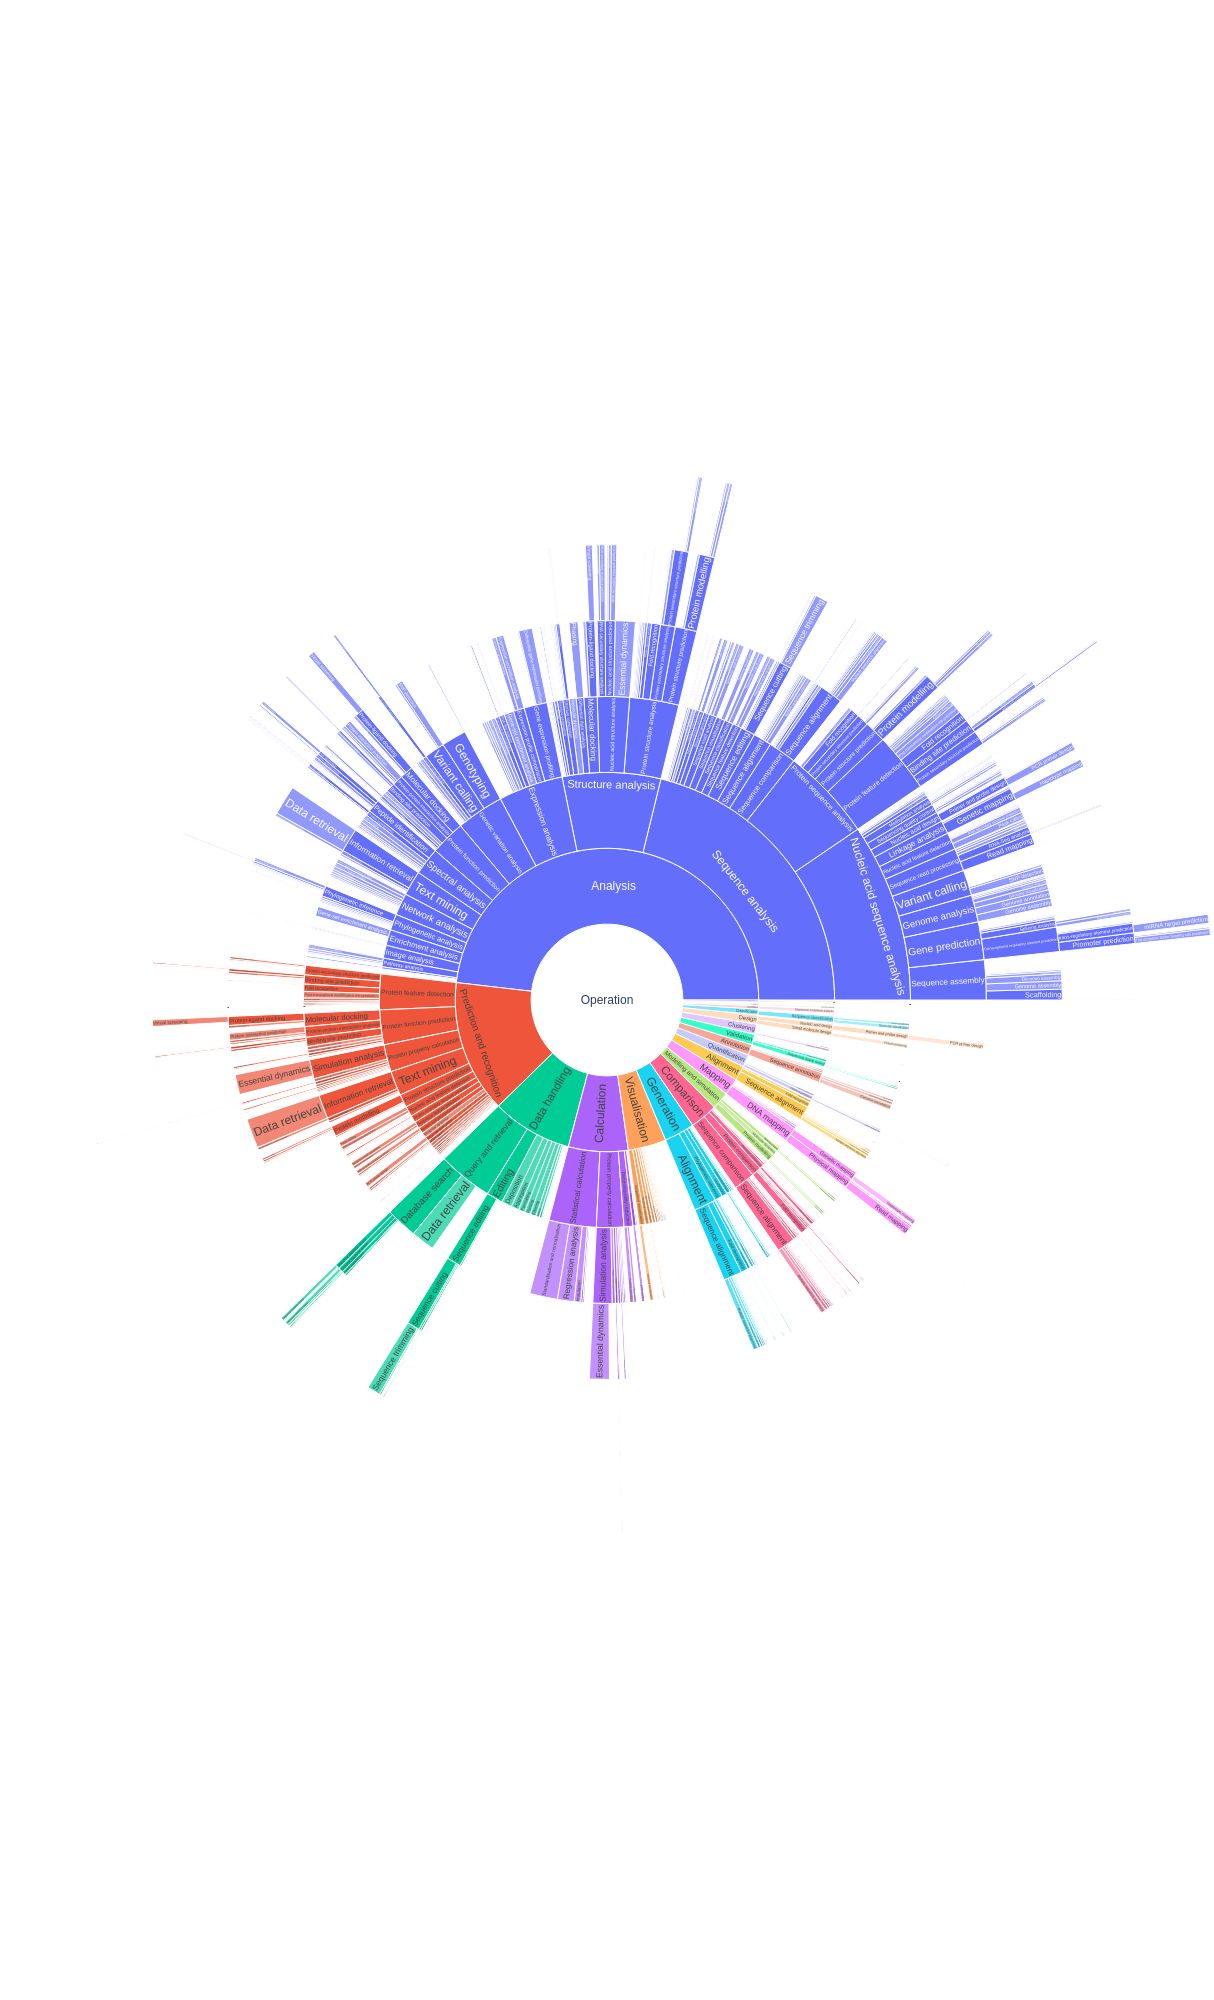

In [7]:
def operation_usage(operation):
    return biotools_operations.get(operation.iri, 0)

sunburst_data, root_node_value = get_sunburst_data(EDAM["operation_0004"], None, "", operation_usage)
# print(sunburst_data)
display_sunburst(sunburst_data)

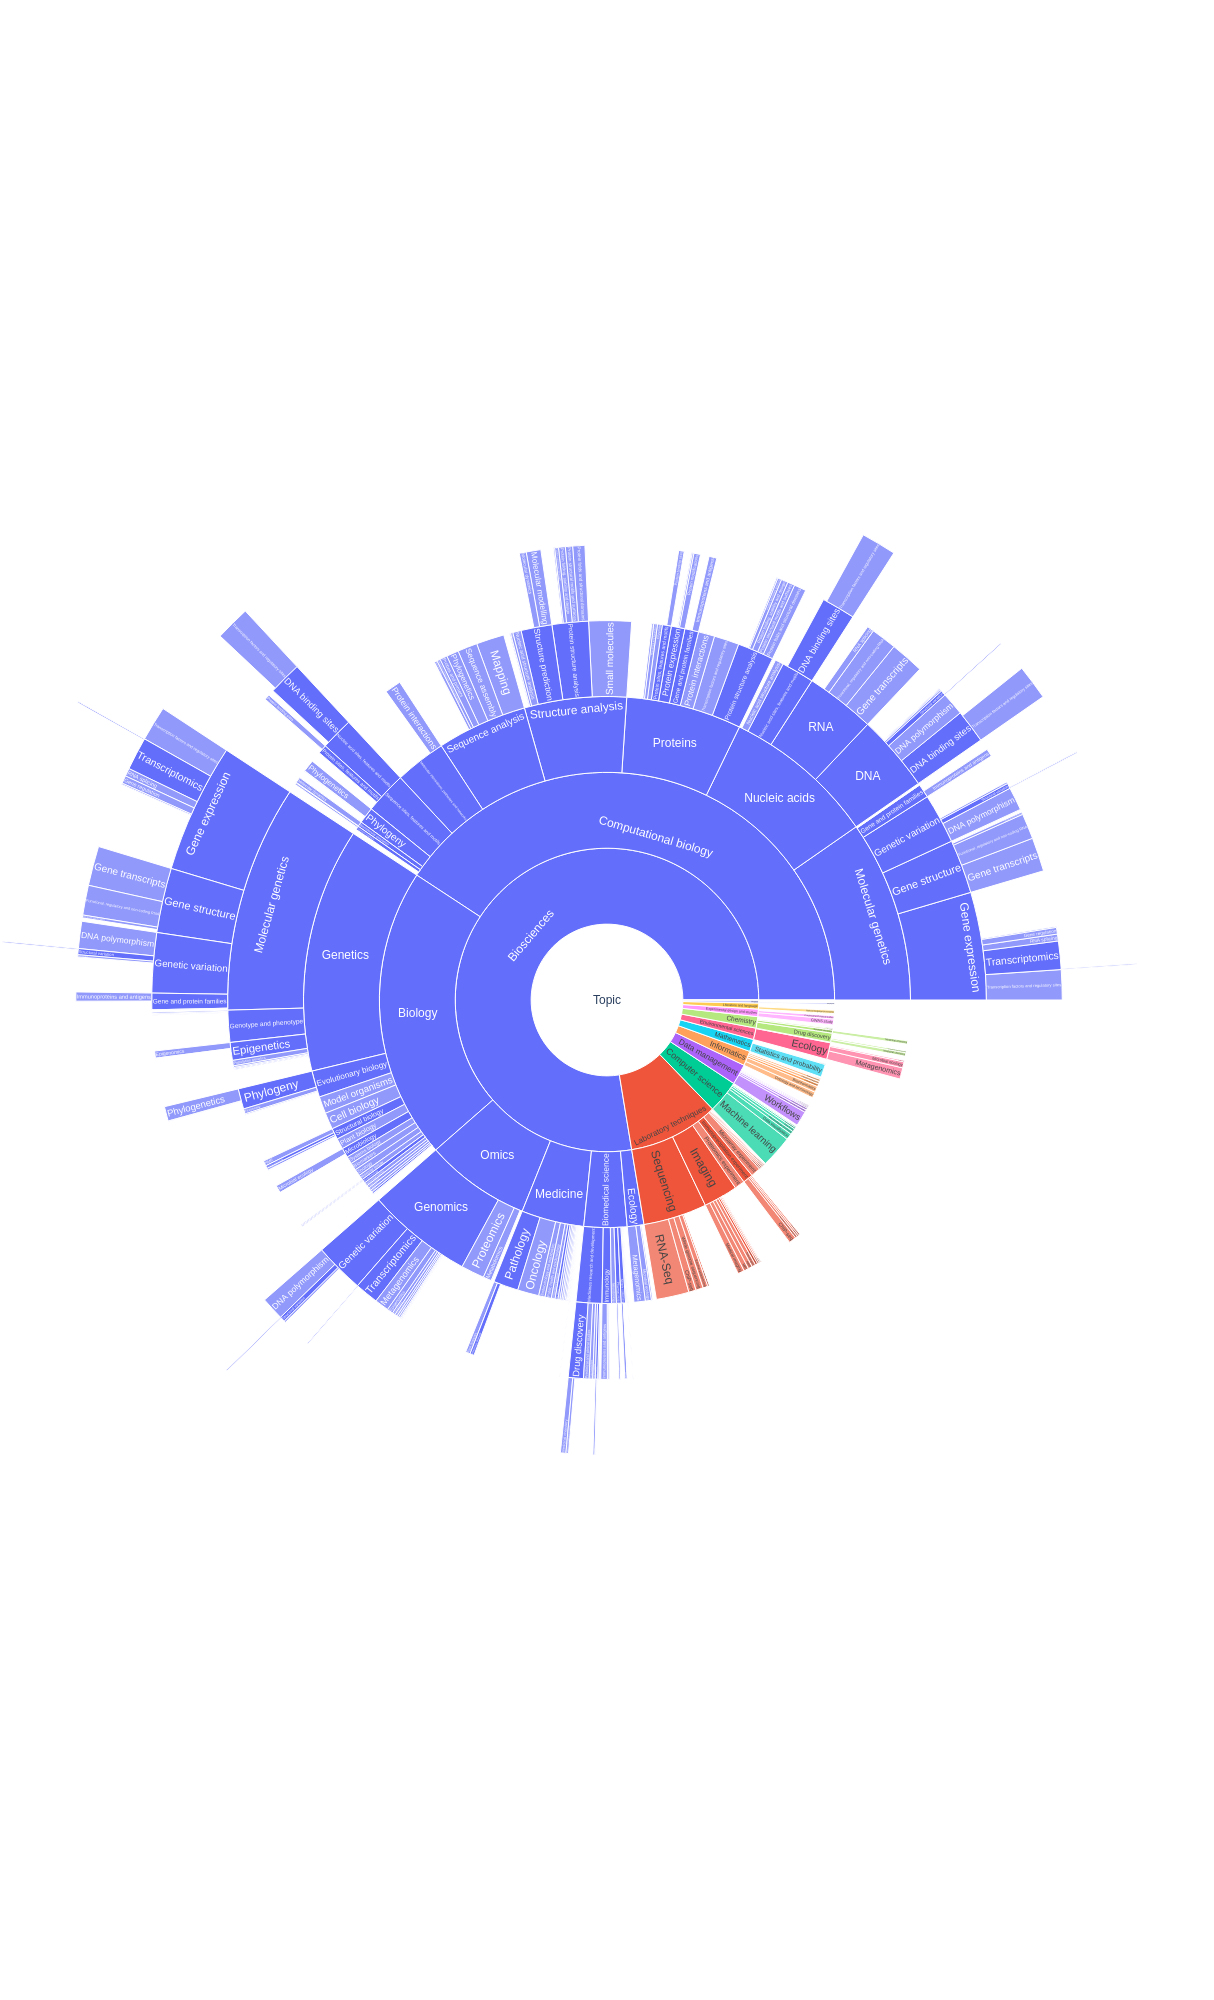

In [8]:
def topic_usage(topic):
    return biotools_topics.get(topic.iri, 0)

sunburst_data, root_node_value = get_sunburst_data(EDAM["topic_0003"], None, "", topic_usage)
display_sunburst(sunburst_data)

In [9]:
def data_usage(data):
    return biotools_data.get(data.iri, 0)

sunburst_data, root_node_value = get_sunburst_data(EDAM["data_0006"], None, "", data_usage)
display_sunburst(sunburst_data)

In [10]:
def format_usage(format):
    return biotools_formats.get(format.iri, 0)

sunburst_data, root_node_value = get_sunburst_data(EDAM["format_1915"], None, "", format_usage)
display_sunburst(sunburst_data)